In [12]:
#https://github.com/schlegelp/navis/issues/17
import sys
from unittest.mock import MagicMock

# Mock vispy and relevant submodules
sys.modules['vispy'] = MagicMock()
sys.modules['vispy.util'] = MagicMock()
sys.modules['vispy.gloo'] = MagicMock()
sys.modules['vispy.gloo.util'] = MagicMock()
sys.modules['vispy.util.transforms'] = MagicMock()
sys.modules['vispy.util.quaternion'] = MagicMock()
sys.modules['vispy.geometry'] = MagicMock()
sys.modules['vispy.visuals'] = MagicMock()
# Now you should be able to import navis
import navis
import pymaid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib
import pandas as pd
import sys
from datetime import date
import pickle
import time 
import logging, sys
from scipy.spatial import distance as dist
from scipy import stats as stats
import networkx as nx
from sklearn.linear_model import LinearRegression
import analysis_dataframes as myDF
importlib.reload(myDF)

import ppc_analysis_functions.catmaid_API as cAPI
importlib.reload(cAPI)
import ppc_analysis_functions.figure_plotting as figs
importlib.reload(figs)
logging.disable(sys.maxsize)
import itertools
import matplotlib.pyplot as plt
importlib.reload(pymaid)


# connect to pymaid instance
rm = pymaid.CatmaidInstance('http://catmaid3.hms.harvard.edu/catmaidppc',
      api_token='9afd2769efa5374b8d48cb5c52af75218784e1ff', project_id=1)
labels = pymaid.get_label_list()
mySessions = ['LD187_141216','LD187_141215','LD187_141214','LD187_141213','LD187_141212','LD187_141211',
              'LD187_141210','LD187_141209','LD187_141208','LD187_141207','LD187_141206']
figsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/figures_working/E2I_dir_connectivity/'
workingDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/analysis_dataframes/'
# Define LR colormap and make colorbar



spearman Data Corr: 0.188
n = 220, bootstrap p = 1.000, shuf p = 100.000
Top quart: nan Bottom quart nan
Selective: 0.044 per um Unselective: 0.039 per um
Selective are 11 percent higher


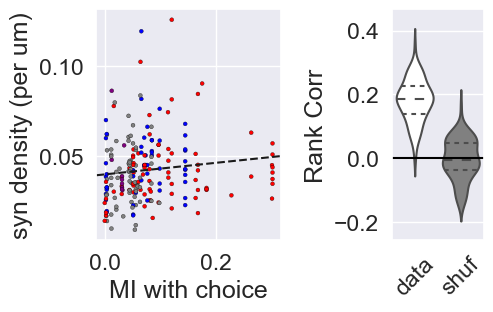

In [923]:
# Plot synapse density vs presynaptic MI (by collat) - NOT USED CURRENTLY
with open(workingDir+'pyr_MN_DF_PPC.pkl', 'rb') as f:  
    neurons_df= pickle.load(f)
collats_df =  myDF.gen_collats_df(neurons_df)
collats_df = collats_df[collats_df.collat_lengths > 50] # 20 um minimum collat length
collats_df = collats_df[collats_df.collat_syn_count > 1] # minimum 2 synapses (eliminate axonal spines off trunk)


sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)
figs.scatter(collats_df, x='select_idx_MI_abs', y='collat_syn_density', sig_test='spearman', hue='selectivity_MI', palette={'Left':'blue', 'Right':'red', 'Non':'gray', 'Mixed':'purple'}, s=8,ax=ax0)
ax0.get_legend().remove()
ax0.set_xlabel('MI with choice')
ax0.set_ylabel('syn density (per um)')
#ax0.set_ylim([0.,.1])
(my_corr_shuf_DF, scores) = figs.compare_corr_vs_1Dshuf(collats_df, x='select_idx_MI_abs', y='collat_syn_density', n_shuf=100)
sns.violinplot(data=my_corr_shuf_DF, x='shuf', y='corrs', scale='width', inner='quartiles', palette = ['white', 'gray'], ax=ax1)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.set_xlabel('')
ax1.set_ylabel('Rank Corr')
ax1.set_xticklabels(['data', 'shuf'],rotation = 45)

top_quart_syn_den = np.mean(collats_df[collats_df.select_idx_MI_abs > np.quantile(collats_df.select_idx_MI_abs.values, 0.75)].collat_syn_density.values)
bottom_quart_syn_den = np.mean(collats_df[collats_df.select_idx_MI_abs < np.quantile(collats_df.select_idx_MI_abs.values, 0.25)].collat_syn_density.values)
select_syn_den = np.mean(collats_df[collats_df.selectivity_MI != 'Non'].collat_syn_density.values)
nonselect_syn_den = np.mean(collats_df[collats_df.selectivity_MI == 'Non'].collat_syn_density.values)
print('Top quart: %.3f Bottom quart %.3f' % (top_quart_syn_den, bottom_quart_syn_den))
print('Selective: %.3f per um Unselective: %.3f per um' % (select_syn_den, nonselect_syn_den))
print('Selective are %i percent higher' % ((select_syn_den - nonselect_syn_den)/nonselect_syn_den * 100))
#plt.savefig(figsDir+'syn_density_vs_MI_PPC_byCollat.pdf',bbox_inches='tight')

Ttest_indResult(statistic=2.871434682147589, pvalue=0.009772553471700227)
MannwhitneyuResult(statistic=16.0, pvalue=0.005071229389880428)
Same: n=13,  0.051 +- 0.007
Opp: n=8, 0.023 +- 0.004


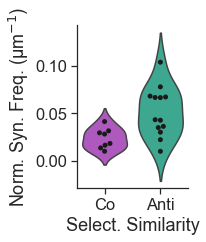

In [14]:
# Compare same/opp for PPC E2I syn density 
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
pal = {-1:'#ba48cf', 1:'#2CB899'}
#with open(workingDir+'dir_cn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(2,3)}, font_scale=1.5, style='ticks')
#f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']
E2I_cn_DF['pair_select_sign'] = np.sign(E2I_cn_DF.pair_select_idx)

ax = sns.violinplot(data=E2I_cn_DF, x='pair_select_sign', y='syn_den', inner=None, palette=pal, scale='width')
sns.swarmplot(data=E2I_cn_DF, x='pair_select_sign', y='syn_den', color = 'k',ax=ax)
ax.set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')
ax.set_xlabel('Select. Similarity')
ax.set_xticklabels(['Co', 'Anti'])

E2I_cn_DF_ex = {}
E2I_cn_DF_ex['Same'] = E2I_cn_DF[np.logical_and(E2I_cn_DF.source==143896,E2I_cn_DF.target==141681)]
E2I_cn_DF_ex['Non'] = E2I_cn_DF[np.logical_and(E2I_cn_DF.source== 144141,E2I_cn_DF.target==24051)]
E2I_cn_DF_ex['Opp'] = E2I_cn_DF[np.logical_and(E2I_cn_DF.source==143494,E2I_cn_DF.target==8357)]
# synapse examples: same. 17169794   non.  17946438 opp.   1282827

my_cn_DF = E2I_cn_DF
same = my_cn_DF[my_cn_DF.pair_select_idx>0].syn_den.values
opp = my_cn_DF[my_cn_DF.pair_select_idx<0].syn_den.values
print(stats.ttest_ind(same, opp))
print(stats.mannwhitneyu(same, opp))
print('Same: n=%i,  %.03f +- %.03f' % (len(same), np.mean(same), stats.sem(same)))
print('Opp: n=%i, %.03f +- %.03f' % (len(opp), np.mean(opp), stats.sem(opp)))
sns.despine()
plt.savefig(figsDir+'syn_density_vs_SameOpp_violin.pdf',bbox_inches='tight')

Ttest_indResult(statistic=-0.0629016040571384, pvalue=0.9506239723534455)
MannwhitneyuResult(statistic=28.0, pvalue=0.14465741619099387)
Same: n=9,  0.031 +- 0.007
Opp: n=9, 0.031 +- 0.004


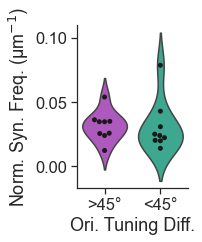

In [11]:
# Compare same/opp for V1 E2I syn density 
with open(workingDir+'dir_cn_DF_V1.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
pal = {-1:'#ba48cf', 1:'#2CB899'}
#with open(workingDir+'dir_cn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(2,3)}, font_scale=1.5, style='ticks')
#f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']
E2I_cn_DF['pair_select_sign'] = np.sign(E2I_cn_DF.pair_select_idx)

ax = sns.violinplot(data=E2I_cn_DF, x='pair_select_sign', y='syn_den', inner=None, palette=pal, scale='width')
sns.swarmplot(data=E2I_cn_DF, x='pair_select_sign', y='syn_den', color = 'k',ax=ax)
ax.set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')
ax.set_xlabel('Ori. Tuning Diff.')
ax.set_xticklabels(['>45°', '<45°'])

E2I_cn_DF_ex = {}
E2I_cn_DF_ex['Same'] = E2I_cn_DF[np.logical_and(E2I_cn_DF.source==143896,E2I_cn_DF.target==141681)]
E2I_cn_DF_ex['Non'] = E2I_cn_DF[np.logical_and(E2I_cn_DF.source== 144141,E2I_cn_DF.target==24051)]
E2I_cn_DF_ex['Opp'] = E2I_cn_DF[np.logical_and(E2I_cn_DF.source==143494,E2I_cn_DF.target==8357)]
# synapse examples: same. 17169794   non.  17946438 opp.   1282827

my_cn_DF = E2I_cn_DF
same = my_cn_DF[my_cn_DF.pair_select_idx>0].syn_den.values
opp = my_cn_DF[my_cn_DF.pair_select_idx<0].syn_den.values
print(stats.ttest_ind(same, opp))
print(stats.mannwhitneyu(same, opp))
print('Same: n=%i,  %.03f +- %.03f' % (len(same), np.mean(same), stats.sem(same)))
print('Opp: n=%i, %.03f +- %.03f' % (len(opp), np.mean(opp), stats.sem(opp)))
sns.despine()
plt.savefig(figsDir+'V1_syn_density_vs_SameOpp_violin.pdf',bbox_inches='tight')

In [175]:
#navis.subset_neuron(n1, [n1.soma, n1.nodes[n1.nodes[0:19]]])
a = n1.nodes[0:1]
b = pymaid.get_node_location(n1.soma)
sub= pd.concat([a,b])
navis.subset_neuron(n1,sub)

type                    CatmaidNeuron
name            new matched neuron 83
id                             150951
n_nodes                             2
n_connectors                        0
n_branches                          0
n_leafs                             0
cable_length                      0.0
soma                         [858134]
units                     1 nanometer
dtype: object

In [2]:
def get_skel_overlaps(n1, n2, min_overlap=5000):
    ix, dist = n2.snap(n1.nodes[['x','y','z']].values)
    n1.nodes['close'] = dist <= min_overlap
    return  navis.subset_neuron(n1, n1.nodes[n1.nodes['close']])

def plot_cn_pair(n1, n1_sidx, n2, n2_sidx, labels, plt_syn=True, plot_whole=True, syn_s = 20, fig_size=(6,4)):
    (n1_axon,  myAxonTrunk, myAxonCollaterals, myMyelination) = cAPI.get_axon_components(n1, labels[labels.skeleton_id == int(n1.skeleton_id)])
    n2_dendrite = cAPI.cut_neuron(n2, labels[labels.skeleton_id == int(n2.skeleton_id)], parts='dendrite')
    n1_overlap = get_skel_overlaps(n1_axon, n2_dendrite, min_overlap=5000)
    print('cable overlap is %f' % n1_overlap.cable_length)
    if plot_whole:
        fig, ax =  navis.plot2d(n1, method='2d', color=figs.RL_colormap(n1_sidx), 
            view=view, linewidth=1, alpha = 1, soma=True, figsize=fig_size)
        navis.plot2d(n2, method='2d', color=figs.RL_colormap(n2_sidx), 
            view=view, linewidth=.5, alpha = 1, soma=True, scalebar = '100 um',ax=ax)
    else:
        n1_axon_soma = navis.subset_neuron(n1, pd.concat([n1_axon.nodes, pymaid.get_node_location(n1.soma)]))
        fig, ax =  navis.plot2d(n1_axon_soma, method='3d_complex', color=figs.RL_colormap(n1_sidx), 
            view=view, linewidth=.5, alpha = 1, soma=False, figsize=fig_size)
        navis.plot2d(n2_dendrite, method='3d_complex', color=figs.RL_colormap(n2_sidx), 
            view=view, linewidth=.5, alpha = 1, soma=True, scalebar = '100 um',ax=ax)
    navis.plot2d(n1_overlap, method='3d_complex', color='k', 
        view=view, linewidth=2, alpha = 1, soma=False,ax=ax)
    if plt_syn:
        myCns = pymaid.get_connectors_between(n1_axon, n2_dendrite)
        navis.plot2d(np.stack(myCns.connector_loc.values), ax=ax, method='3d_complex',
                    scatter_kws={'s': syn_s,'color': 'green','marker': 'D'},view=view)
    return (fig, ax)

def plot_cn_pair_3d(n1, n1_sidx, n2, n2_sidx, labels, plt_syn=True, plot_whole=True, syn_s = 20, fig_size=(6,4)):
    (n1_axon,  myAxonTrunk, myAxonCollaterals, myMyelination) = cAPI.get_axon_components(n1, labels[labels.skeleton_id == int(n1.skeleton_id)])
    n2_dendrite = cAPI.cut_neuron(n2, labels[labels.skeleton_id == int(n2.skeleton_id)], parts='dendrite')
    n1_overlap = get_skel_overlaps(n1_axon, n2_dendrite, min_overlap=5000)
    n1_axon_soma = navis.subset_neuron(n1, pd.concat([n1_axon.nodes, pymaid.get_node_location(n1.soma)]))
    colors = [figs.RL_colormap(n1_sidx)[0],figs.RL_colormap(n2_sidx)[0],'black']
    myCns = pymaid.get_connectors_between(n1_axon, n2_dendrite)
    cns = np.stack(myCns.connector_loc.values)
    navis.clear3d()

    fig,ax=navis.plot3d([n1_axon_soma, n2_dendrite, n1_overlap, cns], color=colors, 
    scatter_kws={'size':[10, 10], 'color':'green'},  width=1000, height=1000)
    print('cable overlap is %f' % n1_overlap.cable_length)
    return (fig, ax)

In [136]:
# inspect dir cn list to pick example pairs
with open(workingDir+'pyr_dir_cn_DF_PPC.pkl', 'rb') as f:  
    pyr_dir_cn_DF= pickle.load(f)
E2I_cn_DF = pyr_dir_cn_DF[pyr_dir_cn_DF.cn_type == 'E-I']
E2I_cn_DF.sort_values(['syn_den'], inplace=True)
E2I_cn_DF.sort_values(['pair_select_idx'], inplace=True)
E2I_cn_DF[['source','target','source_select_idx','target_select_idx', 'pair_select_idx','cable_overlap', 'syn_den','psd_areas']]


Index(['source', 'target', 'total_psd_area', 'syn_count', 'source_type',
       'target_type', 'cn_type', 'psd_areas', 'avg_psd_area',
       'log_avg_psd_area', 'log_total_psd_area', 'cn_ids', 'source_select_idx',
       'source_select_idx_std', 'source_select_idx_stdmean',
       'source_selectivity', 'source_tCOM', 'source_t_peakMI',
       'target_t_peakMI', 't_peak_diff', 'target_select_idx',
       'target_selectivity', 'target_select_idx_std',
       'target_select_idx_stdmean', 'pair_select_idx', 'pair_selectivity',
       'pair_select_idx_std', 'pair_select_idx_stdmean', 'corr_trial_avg',
       'corr_raw', 'corr_residual', 'cable_overlap', 'syn_den', 'cn_strength'],
      dtype='object')

In [301]:
(n1_axon,  myAxonTrunk, myAxonCollaterals, myMyelination) = cAPI.get_axon_components(n1, labels[labels.skeleton_id == int(n1.skeleton_id)])
n1_axon_soma = navis.subset_neuron(n1, pd.concat([n1_axon.nodes, pymaid.get_node_location(n1.soma)]))
n2_dendrite = cAPI.cut_neuron(n2, labels[labels.skeleton_id == int(n2.skeleton_id)], parts='dendrite')
n1_overlap = get_skel_overlaps(n1_axon, n2_dendrite, min_overlap=5000)
myCns = pymaid.get_connectors_between(n1_axon, n2_dendrite)
cns = np.stack(myCns.connector_loc.values)
n1_sidx = my_cn_DF.source_select_idx
n2_sidx = my_cn_DF.target_select_idx
colors = [figs.RL_colormap(n1_sidx)[0], figs.RL_colormap(n2_sidx)[0], 'black']
fig,ax=navis.plot3d([n1_axon_soma, n2_dendrite, n1_overlap, cns], color=colors, 
    scatter_kws={'size':[10, 10], 'color':'green'},  width=1000, height=1000)



end is myelinated for neuron 143896 (code needs update)


TypeError: cannot unpack non-iterable NoneType object

In [313]:
## plot example pairs - same
with open(workingDir+'MN_DF_PPC.pkl' , 'rb') as f:  
    MN_DF_PPC = pickle.load(f)
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5)
view=('-z','-y')
ax = None
mySkids = [143896,141681]
my_cn_DF = dir_cn_DF[np.logical_and(dir_cn_DF.source==mySkids[0], dir_cn_DF.target==mySkids[1])]
print('Source SI: %0.2f Target SI: %0.2f Pair SI: %0.2f' % (my_cn_DF.source_select_idx, my_cn_DF.target_select_idx, my_cn_DF.pair_select_idx))
print('%i connections with %0.2f overlap = %0.3f syn den' % (my_cn_DF.syn_count, my_cn_DF.cable_overlap, my_cn_DF.syn_den))
n1 = pymaid.get_neuron(mySkids[0])
n2 = pymaid.get_neuron(mySkids[1])
(fix, ax) = plot_cn_pair_3d(n1, my_cn_DF.source_select_idx,n2, my_cn_DF.target_select_idx,labels, plot_whole=False)

#plt.savefig(figsDir+'E2I_cn_example_same.eps',bbox_inches='tight')

Source SI: 0.26 Target SI: 0.09 Pair SI: 0.15
2 connections with 25.69 overlap = 0.078 syn den
end is myelinated for neuron 143896 (code needs update)


TypeError: cannot unpack non-iterable NoneType object

In [128]:
# plot example pairs - non
with open(workingDir+'MN_DF_PPC.pkl' , 'rb') as f:  
    MN_DF_PPC = pickle.load(f)
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5)
view=('z','-y')
ax = None

#mySkids = [150951,24051]
mySkids = [144141,24051] # Gray	
my_cn_DF = dir_cn_DF[np.logical_and(dir_cn_DF.source==mySkids[0], dir_cn_DF.target==mySkids[1])]
print('Source SI: %0.3f Target SI: %0.3f Pair SI: %0.3f' % (my_cn_DF.source_select_idx, my_cn_DF.target_select_idx, my_cn_DF.pair_select_idx))
print('%i connections with %0.2f overlap = %0.3f syn den' % (my_cn_DF.syn_count, my_cn_DF.cable_overlap, my_cn_DF.syn_den))
n1 = pymaid.get_neuron(mySkids[0])
n2 = pymaid.get_neuron(mySkids[1])
(fix, ax) = plot_cn_pair_3d(n1, my_cn_DF.source_select_idx,n2, my_cn_DF.target_select_idx,labels, plt_syn=True, plot_whole=False)
#plt.savefig(figsDir+'E2I_cn_example_non.eps',bbox_inches='tight')

Source SI: -0.004 Target SI: 0.048 Pair SI: -0.014
1 connections with 31.85 overlap = 0.031 syn den
end is myelinated for neuron 144141 (code needs update)


TypeError: cannot unpack non-iterable NoneType object

In [3]:
# plot example pairs - OPP
with open(workingDir+'MN_DF_PPC.pkl' , 'rb') as f:  
    MN_DF_PPC = pickle.load(f)
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5)
view=('-z','-y')
ax = None
mySkids = [143494,8357]
#mySkids = [144125, 8357]
my_cn_DF = dir_cn_DF[np.logical_and(dir_cn_DF.source==mySkids[0], dir_cn_DF.target==mySkids[1])]
print('Source SI: %0.3f Target SI: %0.3f Pair SI: %0.3f' % (my_cn_DF.source_select_idx, my_cn_DF.target_select_idx, my_cn_DF.pair_select_idx))
print('%i connections with %0.2f overlap = %0.3f syn den' % (my_cn_DF.syn_count, my_cn_DF.cable_overlap, my_cn_DF.syn_den))
n1 = pymaid.get_neuron(mySkids[0])
n2 = pymaid.get_neuron(mySkids[1])
(fix, ax) = plot_cn_pair_3d(n1, my_cn_DF.source_select_idx,n2, my_cn_DF.target_select_idx,labels, plot_whole=False, fig_size = (6,8))
#plt.savefig(figsDir+'E2I_cn_example_opp.eps',bbox_inches='tight')

Source SI: -0.085 Target SI: 0.112 Pair SI: -0.097
1 connections with 101.43 overlap = 0.010 syn den


TypeError: cannot unpack non-iterable NoneType object

Data corr = 0.684
Quick est p = 0.001
n = 21, bootstrap p = 0.000, shuf p = 0.001
Same: 0.048 per um Non: 0.041 per um Opp: 0.012 per um
Same are 16 percent more freq than Non
Same are 313 percent more freq than Opp


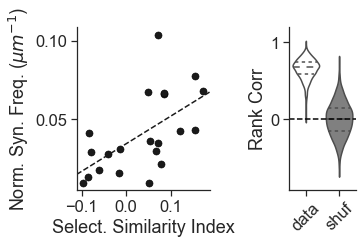

In [4]:
# PPC E2I syn density vs pair_select_idx, PPC
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
#with open(workingDir+'dir_cn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5, style='ticks')
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']

#figs.scatter(E2I_cn_DF, x='pair_select_idx', y='syn_den', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette = {'Opp':'#ba48cf',#'Non':'#A8ADA9','Same':'#2CB899'}, s=50, ax=ax0)
figs.scatter(E2I_cn_DF, x='pair_select_idx', y='syn_den', color='k',sig_test='spearman',s=50, ax=ax0)
ax0.set_xlabel('Select. Similarity Index')
ax0.set_ylabel('Norm. Syn. Freq. ($µm^{-1}$)')
#ax0.set_yscale('log')
#ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_cn_DF, y='syn_den', n_shuf=200)
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], 
inner='quartiles', palette = ['white', 'gray'], cut=2, scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Rank Corr')
ax1.set_xlabel('')
ax1.set_xticklabels(['data', 'shuf'],rotation = 45)

same_syn_den = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Same'].syn_den.values)
non_syn_den  = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Non'].syn_den.values)
opp_syn_den  = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Opp'].syn_den.values)
print('Same: %.3f per um Non: %.3f per um Opp: %.3f per um' % (same_syn_den , non_syn_den , opp_syn_den))
print('Same are %i percent more freq than Non' % ((same_syn_den  - non_syn_den)/non_syn_den * 100))
print('Same are %i percent more freq than Opp' % ((same_syn_den  - opp_syn_den)/opp_syn_den * 100))
sns.despine()
plt.savefig(figsDir+'E2I_syn_den_vs_choice_sim_PPC.pdf',bbox_inches='tight')

Ttest_indResult(statistic=1.9289267535674073, pvalue=0.06431362445581407)
MannwhitneyuResult(statistic=47.0, pvalue=0.014649147202275302)
Same: n=19,  0.231 +- 0.035
Opp: n=10, 0.130 +- 0.027


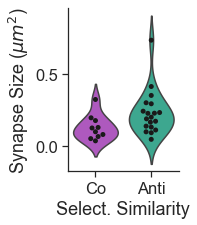

In [5]:
# Compare same/opp for PPC E2I psd area
with open(workingDir+'dir_syn_DF_PPC.pkl', 'rb') as f:  
    dir_syn_DF= pickle.load(f)
pal = {-1:'#ba48cf', 1:'#2CB899'}
#with open(workingDir+'dir_cn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(2,3)}, font_scale=1.5, style='ticks')
#f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_syn_DF = dir_syn_DF[dir_syn_DF.cn_type == 'E-I']
E2I_syn_DF['pair_select_sign'] = np.sign(E2I_syn_DF.pair_select_idx)

ax = sns.violinplot(data=E2I_syn_DF, x='pair_select_sign', y='psd_area',  inner=None, palette=pal, scale='width')
sns.swarmplot(data=E2I_syn_DF, x='pair_select_sign', y='psd_area', color = 'k',ax=ax)
ax.set_ylabel('Synapse Size ($µm^2$)')
ax.set_xlabel('Select. Similarity')
ax.set_xticklabels(['Co', 'Anti'])

my_syn_DF = E2I_syn_DF
same = my_syn_DF[my_syn_DF.pair_select_idx>0].psd_area.values
opp = my_syn_DF[my_syn_DF.pair_select_idx<0].psd_area.values
print(stats.ttest_ind(same, opp))
print(stats.mannwhitneyu(same, opp))
print('Same: n=%i,  %.03f +- %.03f' % (len(same), np.mean(same), stats.sem(same)))
print('Opp: n=%i, %.03f +- %.03f' % (len(opp), np.mean(opp), stats.sem(opp)))
sns.despine()
plt.savefig(figsDir+'psd_area_vs_SameOpp_violin.pdf',bbox_inches='tight')

Data corr = 0.494
Quick est p = 0.006
n = 29, bootstrap p = 0.003, shuf p = 0.004
Same: 0.284 um2 Non: 0.167 um2 Opp: 0.101 um2
Same are 70 percent larger than Non
Same are 181 percent larger than Opp


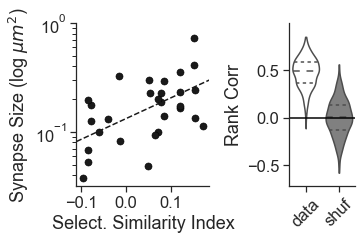

In [6]:
# PPC E2I psd area vs pair_select_idx
with open(workingDir+'dir_syn_DF_PPC.pkl', 'rb') as f:  
    dir_syn_DF= pickle.load(f)
#with open(workingDir+'dir_syn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_syn_DF= pickle.load(f)
E2I_syn_DF = dir_syn_DF[dir_syn_DF.cn_type == 'E-I']

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5, style='ticks')
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(E2I_syn_DF, x='pair_select_idx', y='psd_area',sig_test='spearman',color= 'k',s=50,  ax=ax0)
ax0.set_xlabel('Select. Similarity Index')
ax0.set_ylabel('Synapse Size (log $µm^2$)')
ax0.set_yscale('log')
ax0.set_ylim([10**-1.5, 10**0])
#ax0.get_legend().remove()
(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_syn_DF, y='psd_area', n_shuf=1000)
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], sig_test='spearman', scale='width', inner='quartiles', palette = ['white', 'gray'], cut=0, ax=ax1)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.set_xlabel('')
ax1.set_ylabel('Rank Corr')
ax1.set_xticklabels(['data', 'shuf'],rotation = 45)

same_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Same'].psd_area.values)
non_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Non'].psd_area.values)
opp_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Opp'].psd_area.values)
print('Same: %.3f um2 Non: %.3f um2 Opp: %.3f um2' % (same_psd_area , non_psd_area , opp_psd_area ))
print('Same are %i percent larger than Non' % ((same_psd_area  - non_psd_area)/non_psd_area * 100))
print('Same are %i percent larger than Opp' % ((same_psd_area  - opp_psd_area)/opp_psd_area * 100))
sns.despine()
plt.savefig(figsDir+'E2I_psd_area_vs_choice_sim_PPC.pdf',bbox_inches='tight')

zoom level = 0
[981018.0, 982618.0, 372636.0, 374236.0, 37840.0]


Stitching:   0%|          | 0/1 [00:00<?, ?it/s]

Loading tiles:   0%|          | 0/2 [00:00<?, ?it/s]

I range is 0 255


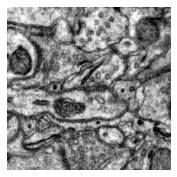

In [123]:
# Export example synapses - Opp
importlib.reload(figs)
mySkids = [143494,8357] # Opp
center = np.array(pymaid.get_connectors_between(mySkids[0], mySkids[1]).connector_loc[0])

img = figs.plot_syn_EM(center, dx = 1600, z_nudge=1, lower=20, upper=240)
plt.savefig(figsDir + "psd_ex_opp.jpeg", bbox_inches='tight', pad_inches = 0, dpi=300)

zoom level = 0
[1126560.0, 1128160.0, 401192.0, 402792.0, 59960.0]


Stitching:   0%|          | 0/1 [00:00<?, ?it/s]

Loading tiles:   0%|          | 0/2 [00:00<?, ?it/s]

I range is 0 255


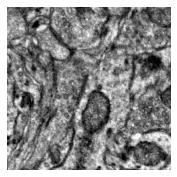

In [132]:
# Export example synapses - Non
importlib.reload(figs)
#mySkids = [150951,24051] # Non
mySkids = [144141,24051] # Non gray
center = np.array(pymaid.get_connectors_between(mySkids[0], mySkids[1]).connector_loc[0])

img = figs.plot_syn_EM(center, dx = 1600, z_nudge=1, lower=20, upper=240)
plt.savefig(figsDir + "psd_ex_non.jpeg", bbox_inches='tight', pad_inches = 0, dpi=300)

zoom level = 0
[1158620.0, 1160220.0, 335742.0, 337342.0, 66960.0]


Stitching:   0%|          | 0/1 [00:00<?, ?it/s]

Loading tiles:   0%|          | 0/4 [00:00<?, ?it/s]

I range is 0 255


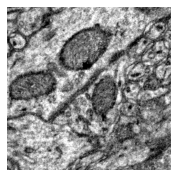

In [107]:
# Export example synapses - Same
importlib.reload(figs)
mySkids = mySkids = [143896,141681]
center = np.array(pymaid.get_connectors_between(mySkids[0], mySkids[1]).connector_loc[0])

img = figs.plot_syn_EM(center, dx = 1600, z_nudge=1, lower=20, upper=240)
plt.savefig(figsDir + "psd_ex_same.jpeg", bbox_inches='tight', pad_inches = 0, dpi=300)

(array([  6.,  20.,  51.,  74.,  93., 104.,  82.,  33.,  24.,  13.]),
 array([ 13. ,  36.6,  60.2,  83.8, 107.4, 131. , 154.6, 178.2, 201.8,
        225.4, 249. ]),
 <BarContainer object of 10 artists>)

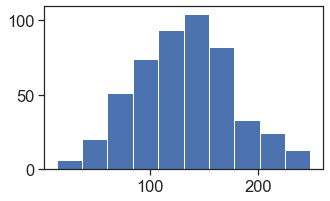

In [97]:
plt.hist(img[100,:])

(0, 0)
143896
(0, 1)
141681
(1, 0)
144141
(1, 1)
24051
(2, 0)
143494
(2, 1)
8357


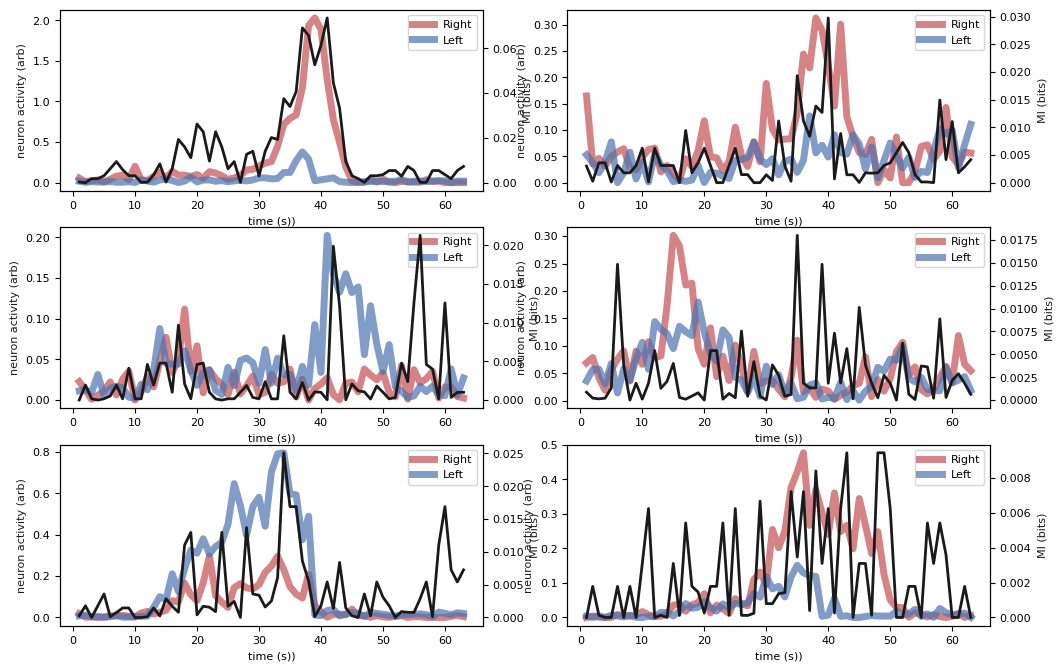

In [742]:
my_skids = [[143896,141681],[144141,24051],[143494,8357]]
f, ax = plt.subplots(3, 2, figsize=(12,8))    
for idx, skid in np.ndenumerate(my_skids):
    print(idx)
    print(skid)
    plot_act(MN_DF_PPC[MN_DF_PPC.skeleton_id == skid], ax=ax[idx[0], idx[1]])

In [738]:
# Utility function for plotting neuron activity
def plot_act(my_DF, ax=None):

    #my_DF = my_DF[my_DF.matched_cell_ID == 7.0]
    plt.style.use('default')
    plt.rcParams['font.size'] = 8
    
    if ax is not None:
        ax1 = ax
    else:
        fig, ax1 = plt.subplots(figsize=(5.5, 4))
    ax1.plot(np.linspace(1,63,num=63),my_DF['Ca_trial_mean_bR'].values[0],'r-', linewidth=5, alpha=.7)
    ax1.plot(np.linspace(1,63,num=63),my_DF['Ca_trial_mean_wL'].values[0],'b-',linewidth=5, alpha=.7)
    ax2 = ax1.twinx()
    ax2.plot(np.linspace(1,63,num=63),my_DF['MI_trial_avg'].values[0][13:],'k-',linewidth=2)

    ax1.legend(['Right', 'Left'])
    ax1.set_ylabel('neuron activity (arb)', color='k')
    ax1.set_facecolor('w')
    ax1.set_xlabel('time (s))')
    ax2.set_ylabel('MI (bits)', color='k')


Data corr = 0.684
Quick est p = 0.001
n = 21, bootstrap p = 0.000, shuf p = 0.000


[Text(0, 0, 'data'), Text(1, 0, 'shuf')]

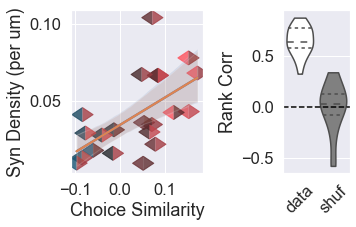

In [635]:
# Try using marker colors to indicate source and target selectivities
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
#with open(workingDir+'dir_cn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']
E2I_cn_DF['source_select_idx_abs'] = np.abs(E2I_cn_DF['source_select_idx'])
E2I_cn_DF['target_select_idx_abs'] = np.abs(E2I_cn_DF['target_select_idx'])

#figs.scatter(E2I_cn_DF, x='pair_select_idx', y='syn_den', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette = 
#{'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=50, ax=ax0)
sns.regplot(data=E2I_cn_DF, x='pair_select_idx', y='syn_den',
    scatter_kws={'facecolors':figs.colormap(E2I_cn_DF['source_select_idx'].values), 's':200},marker=8,ax=ax0)
sns.regplot(data=E2I_cn_DF, x='pair_select_idx', y='syn_den',
    scatter_kws={'facecolors':figs.colormap(E2I_cn_DF['target_select_idx'].values), 's':200},marker=9,ax=ax0)
ax0.set_xlabel('Choice Similarity')
ax0.set_ylabel('Syn Density (per um)')
#ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_cn_DF, x='pair_select_idx',y='syn_den', n_shuf=20)
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], 
inner='quartiles', palette = ['white', 'gray'], cut=0, scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Rank Corr')
ax1.set_xlabel('')
ax1.set_xticklabels(['data', 'shuf'],rotation = 45)

early
Data corr = 0.364
Quick est p = 0.182
n = 15, bootstrap p = 0.110, shuf p = 0.080
middle
Data corr = 0.307
Quick est p = 0.201
n = 19, bootstrap p = 0.110, shuf p = 0.150
late
Data corr = 0.684
Quick est p = 0.001
n = 21, bootstrap p = 0.000, shuf p = 0.000


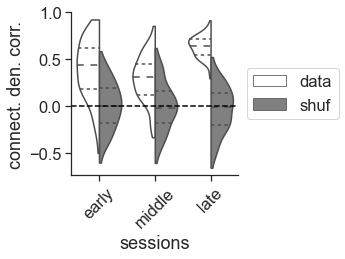

In [153]:
# PPC E2I syn density vs pair_select_idx by session

#plt.subplots_adjust(hspace = .4, wspace=0.8)
sessions = ['early','middle','late']
shuf_df_all = pd.DataFrame()
plot_dict = {}
for sess in sessions:
    print(sess)
    with open(workingDir+'dir_cn_DF_PPC_'+sess+'.pkl', 'rb') as f:  
        dir_cn_DF= pickle.load(f)

    E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']
    E2I_cn_DF['log_syn_den'] = np.log10(E2I_cn_DF.syn_den.values)
    plot_dict[sess] = E2I_cn_DF
    (shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_cn_DF, y='syn_den', n_shuf=100, sig_test='spearman')
    shuf_df['sessions'] = sess
    shuf_df_all = pd.concat([shuf_df_all, shuf_df])
'''
sns.set(rc={'figure.figsize':(9,3)}, font_scale=1.5, style='ticks')
f, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
for idx,ax in enumerate((ax0, ax1, ax2)):
    figs.scatter(plot_dict[sessions[idx]], x='pair_select_idx', y='syn_den', s=50, ax=ax)
    #ax.get_legend().remove()
    ax.set_xlabel('Select. Sim. Idx.')
    ax.set_xlim([-.18, .18])
    ax.set_title(sessions[idx])
    if idx == 0:
        ax.set_ylabel('Norm. Syn. Freq. ($µm^{-1}$)')
    else:
        ax.get_yaxis().set_visible(False)
sns.despine()
plt.savefig(figsDir+'E2I_syn_den_vs_choice_sim_Sessions_datapoints.pdf',bbox_inches='tight')
'''
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')
g=sns.violinplot(data = shuf_df_all[shuf_df_all['shuf'].isin(['data','shuf'])], x='sessions',split=True,hue='shuf', y='corrs', 
    ci='sd', hue_order = ['data', 'shuf'], inner='quartiles', palette = ['white', 'gray'], cut=0, scale='width')
g.axhline(y=0, color='black', linestyle='--')
g.set_ylabel('connect. den. corr.')
g.set_xticklabels(['early','middle','late'],rotation = 45)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#g.get_legend().remove()

sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(figsDir+'E2I_syn_den_vs_choice_sim_Sessions_corrs.pdf',bbox_inches='tight')


early
Data corr = 0.011
Quick est p = 0.966
n = 19, bootstrap p = 0.462, shuf p = 0.466
middle
Data corr = 0.357
Quick est p = 0.087
n = 24, bootstrap p = 0.068, shuf p = 0.038
late
Data corr = 0.494
Quick est p = 0.006
n = 29, bootstrap p = 0.008, shuf p = 0.010


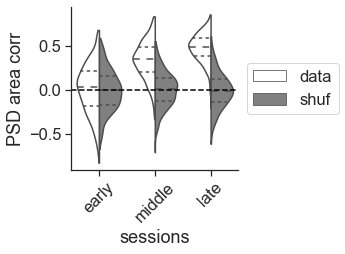

In [152]:
# PPC E2I syn psd area vs pair_select_idx by session
#plt.subplots_adjust(hspace = .4, wspace=0.8)
sessions = ['early','middle','late']
shuf_df_all = pd.DataFrame()
plot_dict = {}
for sess in sessions:
    print(sess)
    with open(workingDir+'dir_syn_DF_PPC_'+sess+'.pkl', 'rb') as f:  
        dir_cn_DF= pickle.load(f)

    E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']
    #E2I_cn_DF['log_syn_den'] = np.log10(E2I_cn_DF.syn_den.values)
    plot_dict[sess] = E2I_cn_DF
    (shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_cn_DF, y='psd_area', n_shuf=500)
    shuf_df['sessions'] = sess
    shuf_df_all = pd.concat([shuf_df_all, shuf_df])
'''
sns.set(rc={'figure.figsize':(9,3)}, font_scale=1.5, style='ticks')
f, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
for idx,ax in enumerate((ax0, ax1, ax2)):
    figs.scatter(plot_dict[sessions[idx]], x='pair_select_idx', y='log_psd_area', sig_test='spearman', s=50, ax=ax)
    #ax.get_legend().remove()
    ax.set_xlabel('Select. Sim. Idx.')
    ax.set_xlim([-.18, .18])
    ax.set_title(sessions[idx])
    if idx == 0:
        ax.set_ylabel('Synapse Size (log $µm^2$)')
    else:
        ax.get_yaxis().set_visible(False)
sns.despine()
plt.savefig(figsDir+'E2I_psd_area_vs_choice_sim_Sessions_datapoints.pdf',bbox_inches='tight')
'''
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')
g=sns.violinplot(data = shuf_df_all[shuf_df_all['shuf'].isin(['data','shuf'])], x='sessions',split=True,hue='shuf', y='corrs', 
    ci='sd', hue_order = ['data', 'shuf'], inner='quartiles', palette = ['white', 'gray'], cut=0, scale='width')
g.axhline(y=0, color='black', linestyle='--')
g.set_ylabel('PSD area corr')
g.set_xticklabels(['early','middle','late'],rotation = 45)
#g.get_legend().remove()
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.savefig(figsDir+'E2I_psd_area_vs_choice_sim_Sessions_corrs.pdf',bbox_inches='tight')



In [26]:
# Plot synapse density vs presynaptic MI (by neuron)
with open(workingDir+'pyr_MN_DF_PPC.pkl', 'rb') as f:  
    neurons_df= pickle.load(f)
#neurons_df = neurons_df[neurons_df.selectivity_MI != 'Mixed']
neurons_df = neurons_df[neurons_df.num_axon_collateral_synapses >= 1]
#neurons_df = neuron_df[neurons_df.select_idx_MI<0]
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)
figs.scatter(neurons_df, x='select_idx_MI_abs', y='syn_density_collat', sig_test='spearman', hue='selectivity_MI', palette={'Left':'blue', 'Right':'red', 'Non':'gray', 'Mixed':'purple'}, s=8,ax=ax0)
ax0.get_legend().remove()
ax0.set_xlabel('MI with trial-type')
ax0.set_ylabel('syn density (per um)')

#ax0.set_ylim([0.,.1])
(my_corr_shuf_DF, scores) = figs.compare_corr_vs_1Dshuf(neurons_df, x='select_idx_MI_abs', y='syn_density_collat', n_shuf=1000)
sns.violinplot(data=my_corr_shuf_DF, x='shuf', y='corrs', scale='width', inner='quartiles', palette = ['white', 'gray'], cut=0, ax=ax1)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.set_xlabel('')
ax1.set_ylabel('Rank Corr')
ax1.set_xticklabels(['data', 'shuf'],rotation = 45)

top_quart_syn_den = np.mean(collats_df[collats_df.select_idx_MI_abs > np.quantile(collats_df.select_idx_MI_abs.values, 0.75)].collat_syn_density.values)
bottom_quart_syn_den = np.mean(collats_df[collats_df.select_idx_MI_abs < np.quantile(collats_df.select_idx_MI_abs.values, 0.25)].collat_syn_density.values)
select_syn_den = np.mean(collats_df[collats_df.selectivity_MI != 'Non'].collat_syn_density.values)
nonselect_syn_den = np.mean(collats_df[collats_df.selectivity_MI == 'Non'].collat_syn_density.values)
print('Top quart: %.3f Bottom quart %.3f' % (top_quart_syn_den, bottom_quart_syn_den))
print('Selective: %.3f per um Unselective: %.3f per um' % (select_syn_den, nonselect_syn_den))
print('Selective are %i percent higher' % ((select_syn_den - nonselect_syn_den)/nonselect_syn_den * 100))
#plt.savefig(figsDir+'syn_density_vs_MI_PPC_byNeuron.pdf',bbox_inches='tight')

spearman Data Corr: 0.195
n = 86, bootstrap p = 4.200, shuf p = 96.200


NameError: name 'collats_df' is not defined

spearman Data Corr: 0.207
n = 71, bootstrap p = 4.300, shuf p = 95.700
n = 676 synapses
Selective: 0.205 um2 Unselective: 0.187 um2
Selective are 9 percent larger


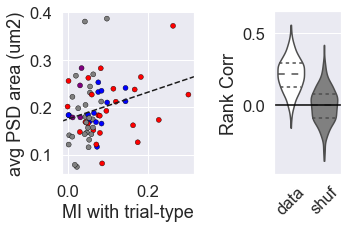

In [2]:
# Is psd out size correlated to selectivity or trial SNR? E2I, by neuron
# TODO fit and stats based on error bars
with open('local_data/pyr_MN_neuronDF_PPC.pkl' , 'rb') as f:  
    pyrMN_DF_PPC = pickle.load(f)
with open(workingDir+'pyr_MN_DF_PPC.pkl','rb') as f:
    pyrMN_DF_PPC = pickle.load(f)
with open('local_data/pyrMN_synDF_PPC.pkl' , 'rb') as f:  
    pyr_syn_DF_PPC = pickle.load(f)
with open(workingDir+'pyr_syn_DF_PPC.pkl', 'rb') as f:  
    pyr_syn_DF_PPC = pickle.load(f)

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_syn_DF_src = cAPI.calc_syn_size_dists(pyr_syn_DF_PPC, source_type = 'pyramidal', target_type = 'non pyramidal')
#E2I_syn_DF_src = E2I_syn_DF_src[E2I_syn_DF_src.select_idx_stdmean > 0]
E2I_syn_DF_src = E2I_syn_DF_src[E2I_syn_DF_src.syn_count >= 2]
#ax0.set_yscale('log')
#ax0.errorbar(x=E2I_syn_DF_src['select_idx_abs'].values,y=E2I_syn_DF_src['avg_psd_area'].values, 
#   yerr=E2I_syn_DF_src['stdmean_psd_area'].values, fmt=' ', color='k',elinewidth=0.5, capsize=1)
figs.scatter(E2I_syn_DF_src,x='select_idx_abs',y='avg_psd_area', hue='selectivity', hue_order=['Left', 'Non','Right','Mixed'], 
    palette=['Blue','Gray','Red','Purple'],s=25, sig_test = 'spearman', ax=ax0)#, errs='stdmean_psd_area', plot_errs=True)
ax0.get_legend().remove()
ax0.set_xlabel('MI with trial-type')
ax0.set_ylabel('avg PSD area (um2)')
#ax0.set_yscale('log')
(my_corr_shuf_DF, scores) = figs.compare_corr_vs_1Dshuf(E2I_syn_DF_src, x='select_idx_abs', y='avg_psd_area', n_shuf=1000)
sns.violinplot(data=my_corr_shuf_DF, x='shuf', y='corrs', scale='width', inner='quartiles', palette = ['white', 'gray'], cut=0, ax=ax1)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.set_xlabel('')
ax1.set_ylabel('Rank Corr')
ax1.set_xticklabels(['data', 'shuf'],rotation = 45)

print('n = %i synapses' % np.sum(E2I_syn_DF_src.syn_count.values))

select_psd_area = np.mean(E2I_syn_DF_src[E2I_syn_DF_src.selectivity != 'Non'].avg_psd_area.values)
nonselect_psd_area = np.mean(E2I_syn_DF_src[E2I_syn_DF_src.selectivity == 'Non'].avg_psd_area.values)
print('Selective: %.3f um2 Unselective: %.3f um2' % (select_psd_area, nonselect_psd_area))
print('Selective are %i percent larger' % ((select_psd_area - nonselect_psd_area)/nonselect_psd_area * 100))
#plt.savefig(figsDir+'E2I_avg_psd_area_vs_MI_PPC.pdf',bbox_inches='tight')



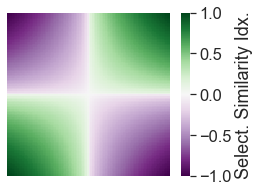

In [139]:
# Heatmap of choice similarity values
n = 100
xvals,yvals = np.linspace(1,-1,n), np.linspace(-1,1,n)
csim = np.zeros((n,n))
csim_df = pd.DataFrame([])
for ix,x in enumerate(xvals):
    for iy, y in enumerate(yvals):
        csim[ix, iy] = myDF.add_pair_select_idx(x, y)
        csim_s = pd.Series({'x':xvals, 'y':yvals, 'csim':csim[ix,iy]})
        csim_df = csim_df.append(csim_s, ignore_index=True)
sns.set(rc={'figure.figsize':(4,3)}, font_scale=1.5)
ax = sns.heatmap(csim, cmap='PRGn', xticklabels=False, yticklabels=False,
    square=True, cbar_kws={'label': 'Select. Similarity Idx.'})
plt.savefig(figsDir+'Choice_Sim_Ex.pdf',bbox_inches='tight')

Ttest_indResult(statistic=-1.347655360446157, pvalue=0.18301003403657815)
MannwhitneyuResult(statistic=329.0, pvalue=0.03793924394589331)
Same: n=29,  0.104 +- 0.011
Opp: n=31, 0.124 +- 0.009


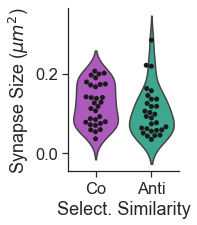

In [15]:
# Compare same/opp for V1 E2I psd area
with open(workingDir+'dir_syn_DF_V1.pkl', 'rb') as f:  
    dir_syn_DF= pickle.load(f)
pal = {-1:'#ba48cf', 1:'#2CB899'}
#with open(workingDir+'dir_cn_DF_PPC_1sess.pkl', 'rb') as f:  
#    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(2,3)}, font_scale=1.5, style='ticks')
#f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_syn_DF = dir_syn_DF[dir_syn_DF.cn_type == 'E-I']
E2I_syn_DF['pair_select_sign'] = np.sign(E2I_syn_DF.pair_select_idx)

ax = sns.violinplot(data=E2I_syn_DF, x='pair_select_sign', y='psd_area',  inner=None, palette=pal, scale='width')
sns.swarmplot(data=E2I_syn_DF, x='pair_select_sign', y='psd_area', color = 'k',ax=ax)
ax.set_ylabel('Synapse Size ($µm^{2}$)')
ax.set_xlabel('Select. Similarity')
ax.set_xticklabels(['Co', 'Anti'])

my_syn_DF = E2I_syn_DF
same = my_syn_DF[my_syn_DF.pair_select_idx>0].psd_area.values
opp = my_syn_DF[my_syn_DF.pair_select_idx<0].psd_area.values
print(stats.ttest_ind(same, opp))
print(stats.mannwhitneyu(same, opp))
print('Same: n=%i,  %.03f +- %.03f' % (len(same), np.mean(same), stats.sem(same)))
print('Opp: n=%i, %.03f +- %.03f' % (len(opp), np.mean(opp), stats.sem(opp)))
sns.despine()
plt.savefig(figsDir+'V1_psd_area_vs_SameOpp_violin.pdf',bbox_inches='tight')

Data corr = -0.333
n = 60, bootstrap p = 98.800, shuf p = 0.600
Same: 0.104 um2 Opp: 0.124 um2
Same are -15 percent larger than Opp


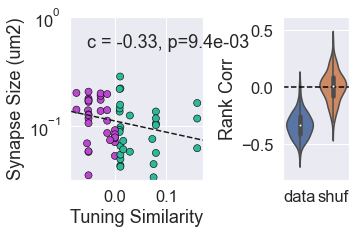

In [433]:
# V1 E2I psd area vs pair_select_idx
with open('local_data/dirMN_synDF_MI_V1.pkl', 'rb') as f:  
    dir_syn_DF= pickle.load(f)
E2I_syn_DF = dir_syn_DF[dir_syn_DF.cn_type == 'E-I']

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(E2I_syn_DF, x='pair_select_idx', y='psd_area', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette =   
    {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=50, plot_errs=True, ax=ax0)
ax0.set_xlabel('Tuning Similarity')
ax0.set_ylabel('Synapse Size (um2)')
ax0.set_yscale('log')
ax0.set_ylim([10**-1.5, 10**0])
ax0.get_legend().remove()
(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_syn_DF, y='psd_area', n_shuf=500, sig_test='spearman')
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], sig_test='spearman', scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_xlabel('')
ax1.set_ylabel('Rank Corr')

same_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Same'].psd_area.values)
opp_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Opp'].psd_area.values)
print('Same: %.3f um2 Opp: %.3f um2' % (same_psd_area, opp_psd_area ))
print('Same are %i percent larger than Opp' % ((same_psd_area  - opp_psd_area)/opp_psd_area * 100))
plt.savefig(figsDir+'E2I_psd_area_vs_choice_sim_V1.pdf',bbox_inches='tight')

Data corr = -0.140
n = 180, bootstrap p = 99.000, shuf p = 2.000
Same: 17.086 um Non: 24.589 um Opp: 35.299 um
Same are -30 percent more overlap Non
Same are -51 percent more overlap Opp


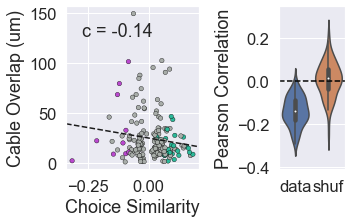

In [14]:
# PPC cable overlap for non-connected pairs
with open('local_data/dirMN_pot_cnDF_MI_PPC.pkl','rb') as f:
    pot_dir_cn_DF = pickle.load(f)

E2I_pot_dir_cn_DF  = pot_dir_cn_DF[pot_dir_cn_DF.cn_type=='E-I']
E2I_pot_dir_cn_DF['connected'] = E2I_pot_dir_cn_DF.syn_count>0
non_connect_DF = E2I_pot_dir_cn_DF[E2I_pot_dir_cn_DF.connected==False]
#non_connect_DF = E2I_pot_dir_cn_DF
#non_connect_DF = non_connect_DF[non_connect_DF.cable_overlap > 20]

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(non_connect_DF, x='pair_select_idx', y='cable_overlap', errs = 'pair_select_idx_stdmean', sig_test='pearson',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=20, ax=ax0)
ax0.set_xlabel('Choice Similarity')
ax0.set_ylabel('Cable Overlap (um)')
ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(non_connect_DF, y='cable_overlap', n_shuf=100, sig_test='pearson')
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Pearson Correlation')
ax1.set_xlabel('')

same_cable_overlap = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Same'].cable_overlap.values)
non_cable_overlap  = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Non'].cable_overlap.values)
opp_cable_overlap   = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Opp'].cable_overlap.values)
print('Same: %.3f um Non: %.3f um Opp: %.3f um' % (same_cable_overlap , non_cable_overlap , opp_cable_overlap))
print('Same are %i percent more overlap Non' % ((same_cable_overlap  - non_cable_overlap)/non_cable_overlap * 100))
print('Same are %i percent more overlap Opp' % ((same_cable_overlap  - opp_cable_overlap)/opp_cable_overlap * 100))

#plt.savefig(figsDir+'E2I_noncn_cable_overlap_vs_choice_select_PPC.pdf',bbox_inches='tight')

(-0.35871710957645614, 0.1203865485735554)

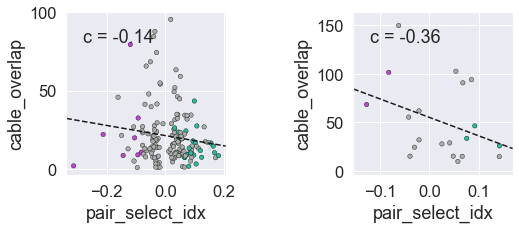

In [17]:
# PPC cable overlap for connected and non-connected pairs
with open('local_data/dirMN_pot_cnDF_MI_PPC.pkl','rb') as f:
    pot_dir_cn_DF = pickle.load(f)

E2I_pot_dir_cn_DF  = pot_dir_cn_DF[pot_dir_cn_DF.cn_type=='E-I']
E2I_pot_dir_cn_DF['connected'] = E2I_pot_dir_cn_DF.syn_count>0
non_connect_DF = E2I_pot_dir_cn_DF[E2I_pot_dir_cn_DF.connected==False]
connect_DF = E2I_pot_dir_cn_DF[E2I_pot_dir_cn_DF.connected==True]

sns.set(rc={'figure.figsize':(8,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(non_connect_DF, x='pair_select_idx', y='cable_overlap', errs = 'pair_select_idx_stdmean', sig_test='pearson',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=20, ax=ax0)
ax0.get_legend().remove()
figs.scatter(connect_DF, x='pair_select_idx', y='cable_overlap', errs = 'pair_select_idx_stdmean', sig_test='pearson',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=20, ax=ax1)
#non_connect_DF = E2I_pot_dir_cn_DF

Data corr = -0.311
n = 18, bootstrap p = 85.000, shuf p = 13.000
Same: 0.031 per um  Opp: 0.031 per um
Same are -1 percent more freq than Opp


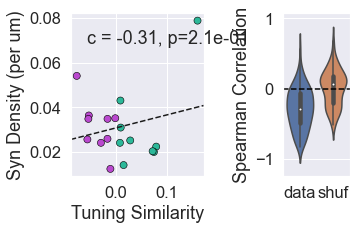

In [434]:
# V1 E2I syn density vs pair_select_idx
with open('local_data/dirMN_cnDF_MI_V1.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-I']

figs.scatter(E2I_cn_DF, x='pair_select_idx', y='syn_den', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=50, ax=ax0)
ax0.set_xlabel('Tuning Similarity')
ax0.set_ylabel('Syn Density (per um)')
ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_cn_DF, y='syn_den', n_shuf=100)
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Spearman Correlation')
ax1.set_xlabel('')

same_syn_den = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Same'].syn_den.values)
opp_syn_den  = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Opp'].syn_den.values)
print('Same: %.3f per um  Opp: %.3f per um' % (same_syn_den , opp_syn_den))
print('Same are %i percent more freq than Opp' % ((same_syn_den  - opp_syn_den)/opp_syn_den * 100))
plt.savefig(figsDir+'E2I_syn_den_vs_choice_sim_V1.pdf',bbox_inches='tight')

Data corr = -0.062
n = 23, bootstrap p = 63.000, shuf p = 50.000
Same: 30.380 um Opp: 30.694 um
Same are -1 percent more overlap Opp
23


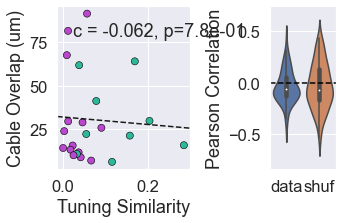

In [435]:
# V1 cable overlap for non-connected pairs
with open('local_data/dirMN_pot_cnDF_MI_V1.pkl','rb') as f:
    pot_dir_cn_DF = pickle.load(f)

E2I_pot_dir_cn_DF  = pot_dir_cn_DF[pot_dir_cn_DF.cn_type=='E-I']
E2I_pot_dir_cn_DF['connected'] = E2I_pot_dir_cn_DF.syn_count>0
non_connect_DF = E2I_pot_dir_cn_DF[E2I_pot_dir_cn_DF.connected==False]

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(non_connect_DF, x='pair_select_idx', y='cable_overlap', errs = 'pair_select_idx_stdmean', sig_test='pearson',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=50, ax=ax0)
ax0.set_xlabel('Tuning Similarity')
ax0.set_ylabel('Cable Overlap (um)')
ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(non_connect_DF, y='cable_overlap', n_shuf=100, sig_test='pearson')
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Pearson Correlation')
ax1.set_xlabel('')

same_cable_overlap = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Same'].cable_overlap.values)
non_cable_overlap  = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Non'].cable_overlap.values)
opp_cable_overlap   = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Opp'].cable_overlap.values)
print('Same: %.3f um Opp: %.3f um' % (same_cable_overlap , opp_cable_overlap))
print('Same are %i percent more overlap Opp' % ((same_cable_overlap  - opp_cable_overlap)/opp_cable_overlap * 100))
print(len(non_connect_DF))
plt.savefig(figsDir+'E2I_noncn_cable_overlap_vs_choice_select_V1.pdf',bbox_inches='tight')

Data corr = 0.059
Quick est p = 0.840
n = 14, bootstrap p = 0.447, shuf p = 0.413
Same: 0.326 um2 Non: 0.290 um2 Opp: 0.154 um2
Same are 12 percent larger than Non
Same are 111 percent larger than Opp


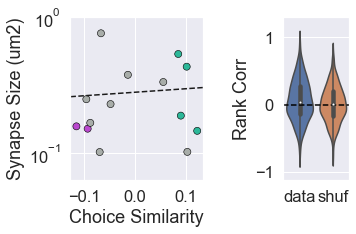

In [35]:
# PPC E2E psd area vs pair_select_idx
with open(workingDir+'dir_syn_DF_PPC.pkl', 'rb') as f:  
    dir_syn_DF= pickle.load(f)
E2I_syn_DF = dir_syn_DF[dir_syn_DF.cn_type == 'E-E']

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(E2I_syn_DF, x='pair_select_idx', y='psd_area', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette =   
    {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=50, plot_errs=True, ax=ax0)
ax0.set_xlabel('Choice Similarity')
ax0.set_ylabel('Synapse Size (um2)')
ax0.set_yscale('log')
ax0.set_ylim([10**-1.2, 10**0])
ax0.get_legend().remove()
(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_syn_DF, y='psd_area', n_shuf=1000)
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], sig_test='spearman', scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_xlabel('')
ax1.set_ylabel('Rank Corr')

same_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Same'].psd_area.values)
non_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Non'].psd_area.values)
opp_psd_area = np.mean(E2I_syn_DF[E2I_syn_DF.pair_selectivity == 'Opp'].psd_area.values)
print('Same: %.3f um2 Non: %.3f um2 Opp: %.3f um2' % (same_psd_area , non_psd_area , opp_psd_area ))
print('Same are %i percent larger than Non' % ((same_psd_area  - non_psd_area)/non_psd_area * 100))
print('Same are %i percent larger than Opp' % ((same_psd_area  - opp_psd_area)/opp_psd_area * 100))
plt.savefig(figsDir+'E2E_psd_area_vs_choice_sim_PPC.pdf',bbox_inches='tight')

Data corr = -0.455
Quick est p = 0.102
n = 14, bootstrap p = 0.044, shuf p = 0.036
Same: 0.030 per um Non: 0.042 per um Opp: 0.067 per um
Same are -29 percent more freq than Non
Same are -55 percent more freq than Opp


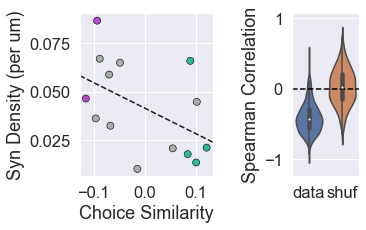

In [36]:
# PPC E2E syn density vs pair_select_idx, PPC
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'E-E']

figs.scatter(E2I_cn_DF, x='pair_select_idx', y='syn_den', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=50, ax=ax0)
ax0.set_xlabel('Choice Similarity')
ax0.set_ylabel('Syn Density (per um)')
ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(E2I_cn_DF, y='syn_den', n_shuf=500)
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Spearman Correlation')
ax1.set_xlabel('')

same_syn_den = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Same'].syn_den.values)
non_syn_den  = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Non'].syn_den.values)
opp_syn_den  = np.mean(E2I_cn_DF[E2I_cn_DF.pair_selectivity == 'Opp'].syn_den.values)
print('Same: %.3f per um Non: %.3f per um Opp: %.3f per um' % (same_syn_den , non_syn_den , opp_syn_den))
print('Same are %i percent more freq than Non' % ((same_syn_den  - non_syn_den)/non_syn_den * 100))
print('Same are %i percent more freq than Opp' % ((same_syn_den  - opp_syn_den)/opp_syn_den * 100))
plt.savefig(figsDir+'E2E_syn_den_vs_choice_sim_PPC.pdf',bbox_inches='tight')

Data corr = -0.002
n = 1371, bootstrap p = 50.400, shuf p = 47.400
Same: 19.375 um Non: 18.316 um Opp: 19.286 um
Same are 5 percent more overlap Non
Same are 0 percent more overlap Opp


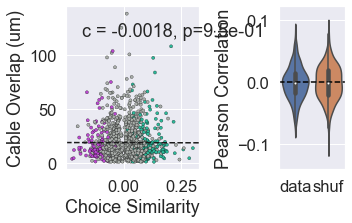

In [424]:
# PPC cable overlap for non-connected pairs
with open('local_data/dirMN_pot_cnDF_MI_PPC.pkl','rb') as f:
    pot_dir_cn_DF = pickle.load(f)

E2I_pot_dir_cn_DF  = pot_dir_cn_DF[pot_dir_cn_DF.cn_type=='E-E']
E2I_pot_dir_cn_DF['connected'] = E2I_pot_dir_cn_DF.syn_count>0
non_connect_DF = E2I_pot_dir_cn_DF[E2I_pot_dir_cn_DF.connected==False]

sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5)
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

figs.scatter(non_connect_DF, x='pair_select_idx', y='cable_overlap', errs = 'pair_select_idx_stdmean', sig_test='pearson',hue='pair_selectivity',  palette = {'Opp':'#ba48cf','Non':'#A8ADA9','Same':'#2CB899'}, s=10, ax=ax0)
ax0.set_xlabel('Choice Similarity')
ax0.set_ylabel('Cable Overlap (um)')
ax0.get_legend().remove()

(shuf_df, scores) = figs.calc_shuffle_comparisons(non_connect_DF, y='cable_overlap', n_shuf=500, sig_test='pearson')
sns.violinplot(data = shuf_df[shuf_df['shuf'].isin(['data','shuf'])], x='shuf', y='corrs', ci='sd', order = ['data', 'shuf'], scale='width', ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel('Pearson Correlation')
ax1.set_xlabel('')

same_cable_overlap = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Same'].cable_overlap.values)
non_cable_overlap  = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Non'].cable_overlap.values)
opp_cable_overlap   = np.mean(non_connect_DF[non_connect_DF.pair_selectivity == 'Opp'].cable_overlap.values)
print('Same: %.3f um Non: %.3f um Opp: %.3f um' % (same_cable_overlap , non_cable_overlap , opp_cable_overlap))
print('Same are %i percent more overlap Non' % ((same_cable_overlap  - non_cable_overlap)/non_cable_overlap * 100))
print('Same are %i percent more overlap Opp' % ((same_cable_overlap  - opp_cable_overlap)/opp_cable_overlap * 100))

plt.savefig(figsDir+'E2E_noncn_cable_overlap_vs_choice_select_PPC.pdf',bbox_inches='tight')